## Intro
This project is aimed at using causual inference techniques with wideley available and relevant data 

In July 2024, Crowdstrike had a widely reported data breach causing the stock price to drop 18% over the
next 3 days. This "bad event" is something companies are regularly worried about and I'm interested
in quantifying impact -- but naturally we dont want do design and experiment that will randomly cause
millions of government computers to crash over and over again. 

Examples of how this might transfer 

Suppose there is an outage that affects a certain region or population of users (in this case infastructure workers) 
IF you have a time series of performance by these groups, you may consider a difference-in-difference model to estimate the impact of the event. 

Note: This is an example where we look at one day returns of an event. In most cases, if we wanted to analyze price movements, we may be more interested in montly or yearly data. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime 
import statsmodels.formula.api as smf 
from yahoo_fin import stock_info as si

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime 
import statsmodels.formula.api as smf 
from yahoo_fin import stock_info as si

In [158]:
def get_daily_prices(ticker,start_date, end_date):
    df = si.get_data(ticker, interval='1d', start_date=start_date, end_date=end_date)
    df.reset_index(inplace=True)  # Ensure the date is a column
    df.rename(columns={'index': 'date'}, inplace=True)  # Rename 'index' to 'date'
    df['price'] = df['adjclose']
    df = df[['date', 'price', 'ticker']]
    return df

In [159]:
def get_prices(tickerlist, start, end):
    all_prices = []  # Use a list to collect DataFrames
    for ticker in tickerlist:
        dailyprices_df = get_daily_prices(ticker, start, end)
        all_prices.append(dailyprices_df)
    df = pd.concat(all_prices)  # Concatenate all DataFrames at once
    return df

In [160]:
def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]
    df['treated'] = np.where(df['ticker'] == treated, 1, 0)
    df['post'] = np.where(df['date'] >= event_date, 1, 0)
    df['treated_post'] = df['treated'] * df['post']

    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula = formula, data = df).fit()
    return model

In [161]:
def difference_in_trends(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=100)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]
    df['treated'] = np.where(df['ticker'] == treated, 1, 0)
    df['trend'] = (event_date - df['date']).dt.days
    df['treated_trend'] = df['treated'] * df['trend']  
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula = formula, data = df).fit()
    return model

In [162]:
start_date = '2024-01-01'
end_date = '2024-07-20'

tickerlist = list(['CRWD', 'MSFT', 'VTI', 'RPD', 'AAPL', 'NVDA' ])
prices = get_prices(tickerlist, start_date, end_date)   
#create a returns column that caluclates the returns for each day
prices['return'] = prices.groupby('ticker')['price'].pct_change()


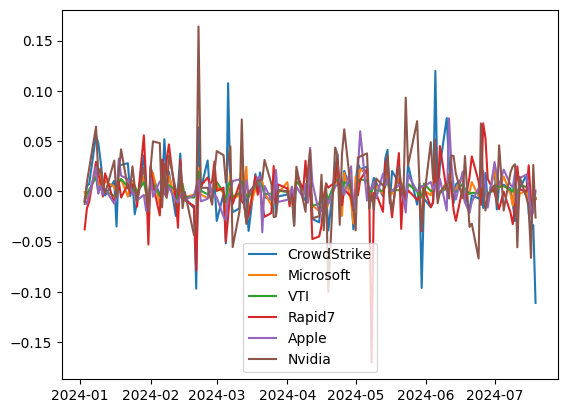

In [163]:
prices['returns'] = prices.groupby('ticker')['price'].pct_change()

crwd = prices[prices['ticker'] == 'CRWD']
msft = prices[prices['ticker'] == 'MSFT']
vti  = prices[prices['ticker'] == 'VTI']
rpd = prices[prices['ticker'] == 'RPD']
aapl = prices[prices['ticker'] == 'AAPL']
nvda = prices[prices['ticker'] == 'NVDA']

plt.plot(crwd['date'], crwd['return'], label='CrowdStrike')
plt.plot(msft['date'], msft['return'], label='Microsoft')
plt.plot(vti['date'], vti['return'], label='VTI')
plt.plot(rpd['date'], rpd['return'], label='Rapid7')
plt.plot(aapl['date'], aapl['return'], label='Apple')
plt.plot(nvda['date'], nvda['return'], label='Nvidia')
plt.legend()
plt.show()

In [164]:
prices[prices['date'] >= "2024-07-16"].iloc[:10,]

,date,price,ticker,return,returns
134,2024-07-16,369.049988,CRWD,-0.022047,-0.022047
135,2024-07-17,354.940002,CRWD,-0.038233,-0.038233
136,2024-07-18,343.049988,CRWD,-0.033499,-0.033499
137,2024-07-19,304.959991,CRWD,-0.111033,-0.111033
134,2024-07-16,449.519989,MSFT,-0.009781,-0.009781
135,2024-07-17,443.519989,MSFT,-0.013348,-0.013348
136,2024-07-18,440.369995,MSFT,-0.007102,-0.007102
137,2024-07-19,437.109985,MSFT,-0.007403,-0.007403
134,2024-07-16,279.100006,VTI,0.008236,0.008236
135,2024-07-17,275.160004,VTI,-0.014117,-0.014117


We see that on the day of the event, the stock dropped by 38%, we want to look at the impact of the returns on that day. 


## Estimate Differnce-in-Differences Model

We're going to estimate returns against a dummy for being in the treated model, in this case is just Crowdstrike. We indicate post as the event date and an interaction between treated and post. 

In [165]:
event_date = pd.to_datetime('2024-07-19')
treated = 'CRWD'

model = run_diff_in_diff(prices, event_date, treated)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     8.403
Date:                Sat, 20 Jul 2024   Prob (F-statistic):           1.69e-05
Time:                        22:43:33   Log-Likelihood:                 1769.4
No. Observations:                 750   AIC:                            -3531.
Df Residuals:                     746   BIC:                            -3512.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0015      0.001      1.675   

C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post'] = np.where(df['date'] >= event_date, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Essentially, we are netting out competitor returns and market returns that happened on the same day. This way, if we saw a fall in Crowdstrike, but there was also a large market movement at the same time, we wouldn't give full credit from that drop in return to the crowdstrike breach. 

In this case, we see that ther was really nothing else going on. Our DID model gives us an estimated drop due to the breach that is almost identical to that days return. 

## Test Validation Assumptions

### Assumption 1: No difference trends prior to the event 

So we can see that our model is working as intended, but we'd like to do some validation work. 

In [166]:
placebo_date = event_date - datetime.timedelta(days=1)
treated = 'CRWD'

test_trend_mn = difference_in_trends(prices, placebo_date, treated)
print(test_trend_mn.summary())



                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2696
Date:                Sat, 20 Jul 2024   Prob (F-statistic):              0.847
Time:                        22:43:33   Log-Likelihood:                 976.32
No. Observations:                 420   AIC:                            -1945.
Df Residuals:                     416   BIC:                            -1928.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0031      0.003      1.230

C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\3666590341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\3666590341.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend'] = (event_date - df['date']).dt.days
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\3666590341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

 Looking at one day prior, we see that Crowdstrike was trending downward, about 3.2 percent. This is also statisically siginificant as our P value is greater than .05.

In [167]:
prices[prices['date'] >= "2024-07-15"].iloc[:10,]

,date,price,ticker,return,returns
133,2024-07-15,377.369995,CRWD,0.016293,0.016293
134,2024-07-16,369.049988,CRWD,-0.022047,-0.022047
135,2024-07-17,354.940002,CRWD,-0.038233,-0.038233
136,2024-07-18,343.049988,CRWD,-0.033499,-0.033499
137,2024-07-19,304.959991,CRWD,-0.111033,-0.111033
133,2024-07-15,453.959991,MSFT,0.000904,0.000904
134,2024-07-16,449.519989,MSFT,-0.009781,-0.009781
135,2024-07-17,443.519989,MSFT,-0.013348,-0.013348
136,2024-07-18,440.369995,MSFT,-0.007102,-0.007102
137,2024-07-19,437.109985,MSFT,-0.007403,-0.007403



 Looking back at our returns for the previous days up until the Breach, we notice that crowdstrike was trending downward. There is some evidence of a trend

### Assumption 2: Model not biased estimates clost to zero when no effect


In [168]:
placebo_date = event_date - datetime.timedelta(days = 1)
treated = 'CRWD'

placebo_model = run_diff_in_diff(prices, placebo_date, treated)
print(placebo_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9086
Date:                Sat, 20 Jul 2024   Prob (F-statistic):              0.436
Time:                        22:43:33   Log-Likelihood:                 1754.0
No. Observations:                 744   AIC:                            -3500.
Df Residuals:                     740   BIC:                            -3481.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0016      0.001      1.718   

C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post'] = np.where(df['date'] >= event_date, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [169]:
placebo_start = event_date - datetime.timedelta(days=120)
pre_event_dates = prices[(prices['date'] >= placebo_start) & (prices['date'] <= event_date)]['date']

pvalues = list()
betas = list()

for placebo_date in pre_event_dates:
    placebo_model = run_diff_in_diff(prices, placebo_date, treated)
    pvalues.append(placebo_model.pvalues['treated'])
    betas.append(placebo_model.params['treated'])
  

df = pd.DataFrame({'placebo_date': pre_event_dates, 'pvalue': pvalues, 'beta': betas})
print(df.describe())

#print the share of p-values that are less than 0.05

print((df['pvalue'] < 0.05).mean())

C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post'] = np.where(df['date'] >= event_date, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

                        placebo_date      pvalue        beta
count                            498  498.000000  498.000000
mean   2024-05-20 06:04:20.240963840    0.496737    0.001802
min              2024-03-21 00:00:00    0.295368    0.000197
25%              2024-04-19 00:00:00    0.387781    0.001505
50%              2024-05-20 00:00:00    0.469720    0.001880
75%              2024-06-20 00:00:00    0.578295    0.002252
max              2024-07-19 00:00:00    0.930508    0.002921
std                              NaN    0.140719    0.000593
0.0


C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post'] = np.where(df['date'] >= event_date, 1, 0)
C:\Users\ramse\AppData\Local\Temp\ipykernel_20208\1905102815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Looking at the distribution of placebo tests, we see that the median beta value is almost zero, along with a P value high enough for our results to be statistically significant

Not Suprisingly, the placebo tests are not independent so we get 5% of p-values less than 0.05. THis suggest that we consider an empirical distribution as in the histogram below

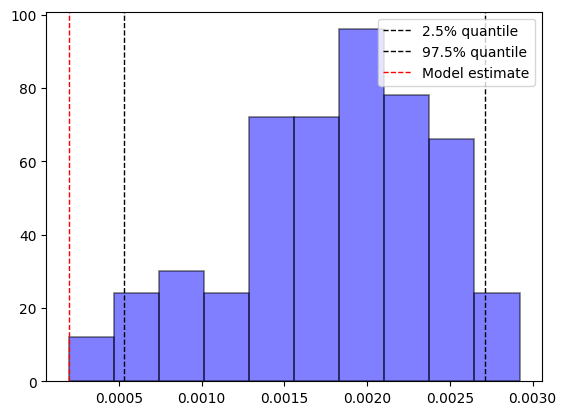

In [170]:
df['betas'] = df['beta']
df['betas'].quantile([0.025, 0.975])

#0.025  0.000534
#0.975  0.002710

quantile_2_5 = df['betas'].quantile(0.025)
quantile_97_5 = df['betas'].quantile(0.975)
model_est = model.params['treated']

plt.hist(df['betas'], bins=10, alpha = 0.5, color = 'blue', edgecolor = 'black', linewidth = 1.2)
plt.axvline(x = quantile_2_5, color = 'black', linestyle = '--', linewidth = 1, label = '2.5% quantile')
plt.axvline(x = quantile_97_5, color = 'black', linestyle = '--', linewidth = 1, label = '97.5% quantile')
plt.axvline(x = model_est, color = 'red', linestyle = '--', linewidth = 1, label = 'Model estimate')
plt.legend(loc='upper right')
plt.show()

#the model should have most of the data around 0.000 and the event 
#should be a far outlier from the rest of the data

